imports and data preperation 

In [249]:

'''imports and setting up our plot as well as dataset setup'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import model_selection
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12,6)

dataset = pd.read_csv("breast_cancer.csv")
# preprocessing of data
dataset.replace('?', -99999, inplace=True)
# get all the data into columns
columns = dataset.columns.tolist()
# remove class and id as they have no effect on the prediction
columns = [c for c in columns if c not in ["Class", "ID"]]
# storing the variable we will prredict with
target = 'Class'

X = dataset[columns]
y = dataset[target]
y = y.map({2: 0, 4: 1})
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, y, train_size=0.7, random_state=0)

show the distribution of the cancer types on the dataset see if there is a skew

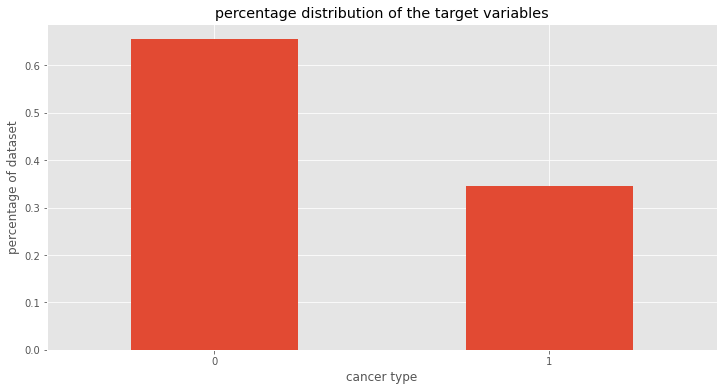

In [250]:
y.value_counts(normalize=True).plot(kind='bar')
plt.title("percentage distribution of the target variables")
plt.xticks(rotation=0)
plt.xlabel('cancer type')
plt.ylabel("percentage of dataset")
plt.show()

show the relationships between variables using pairplots and scatter plots 

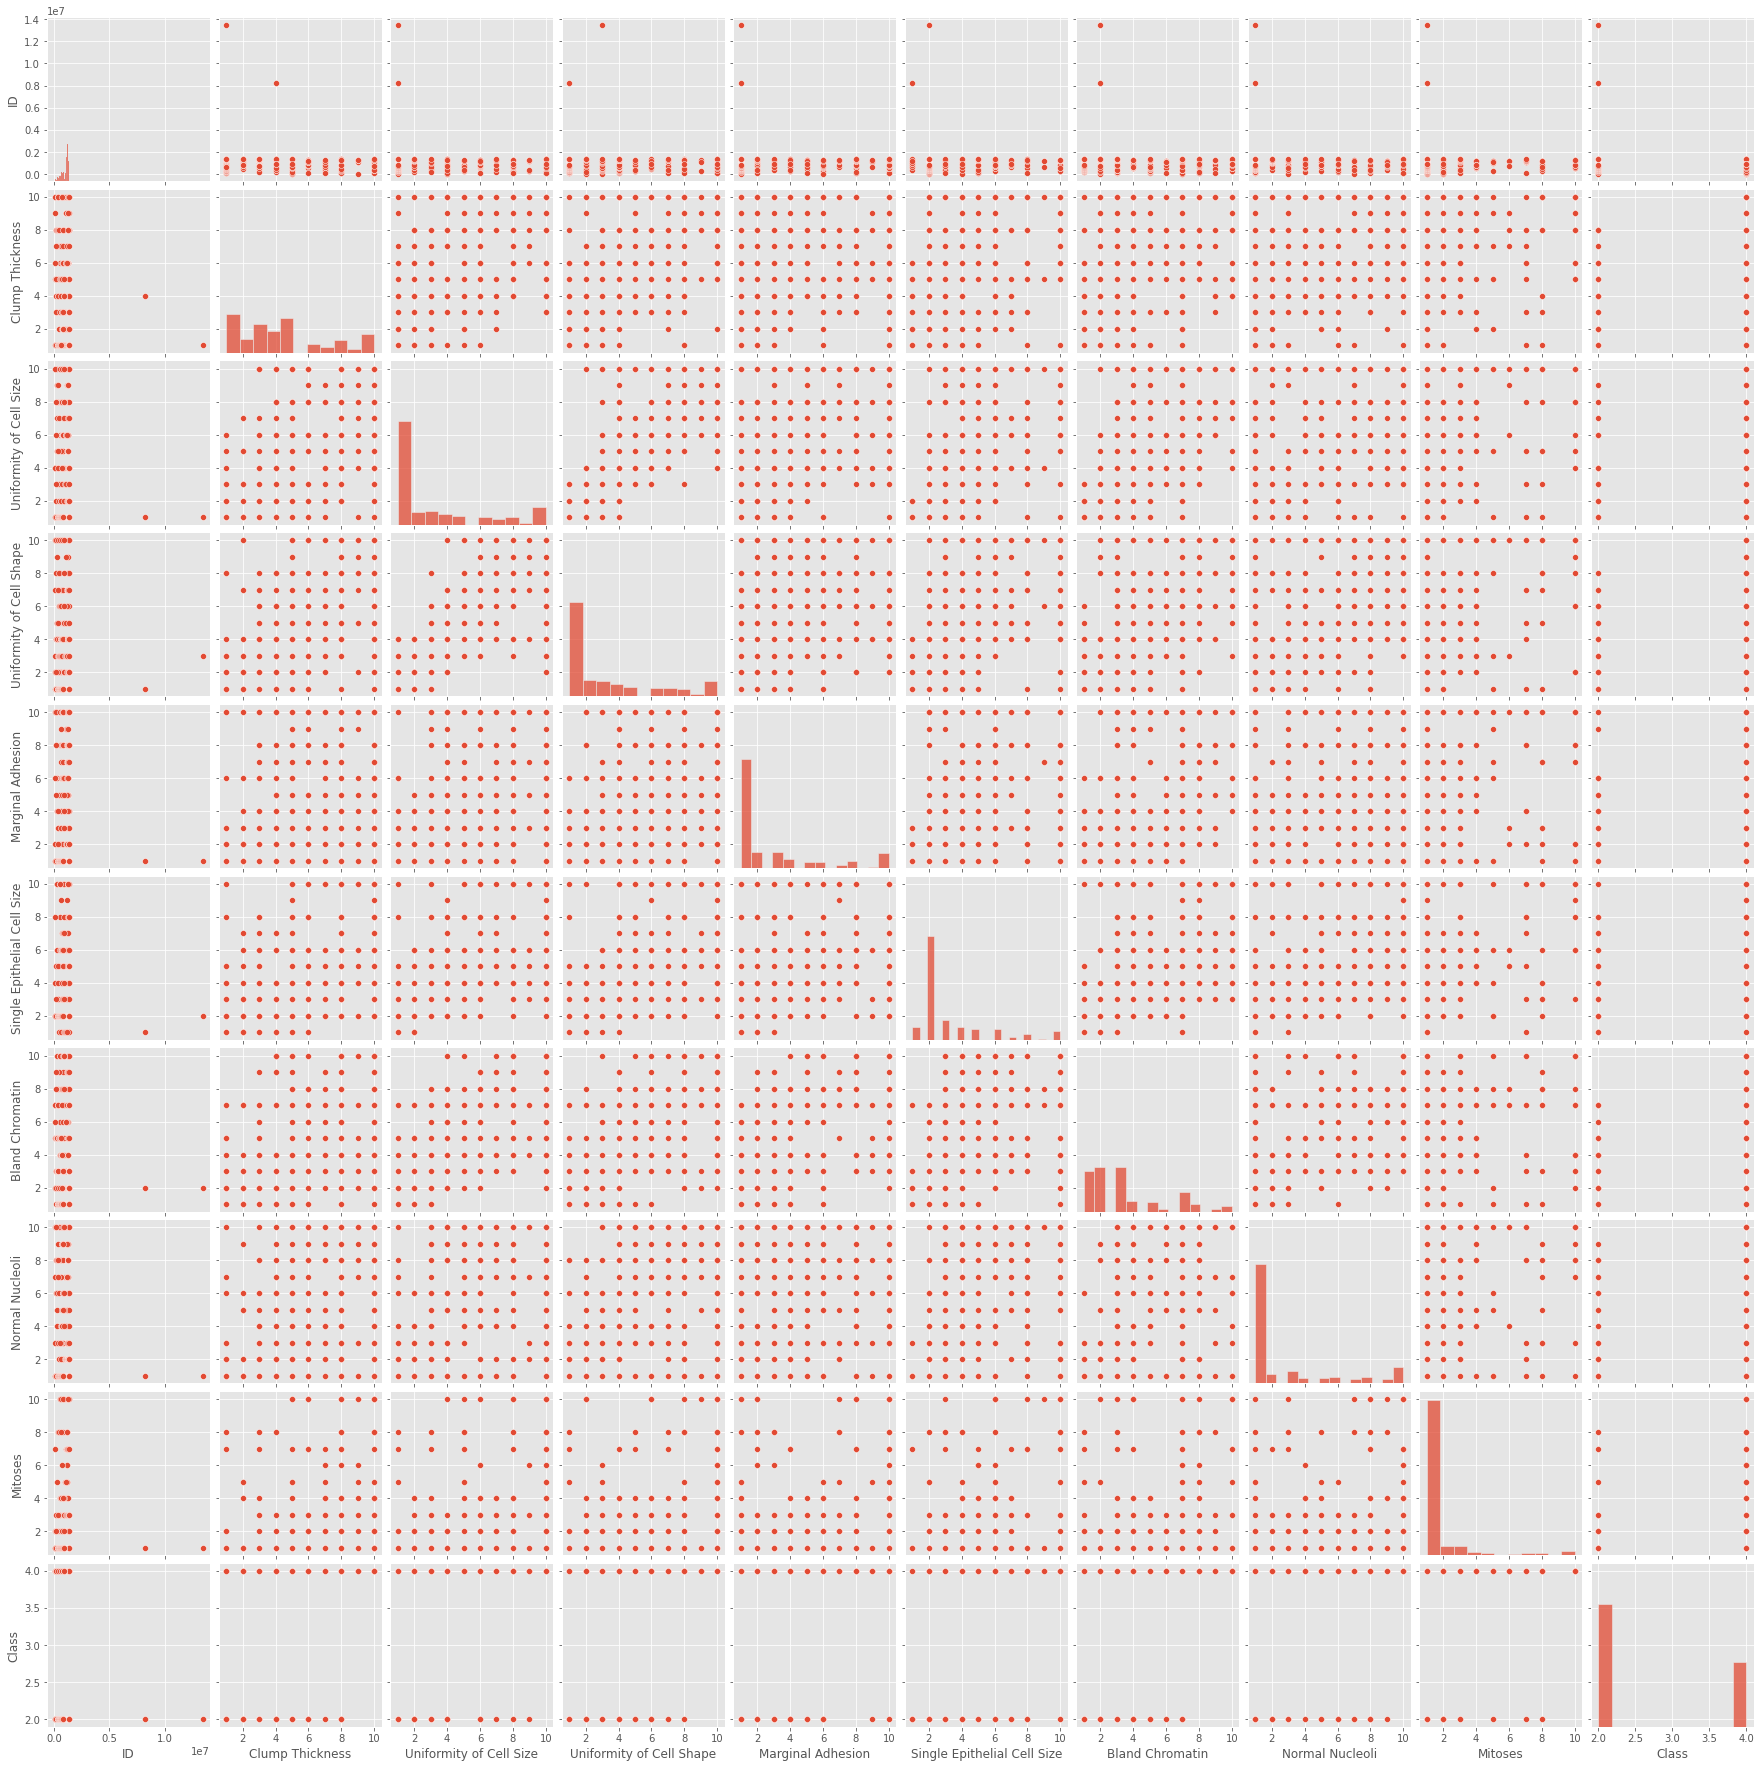

In [251]:
sns.pairplot(dataset)

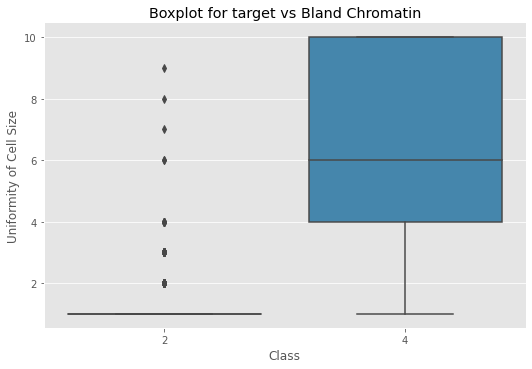

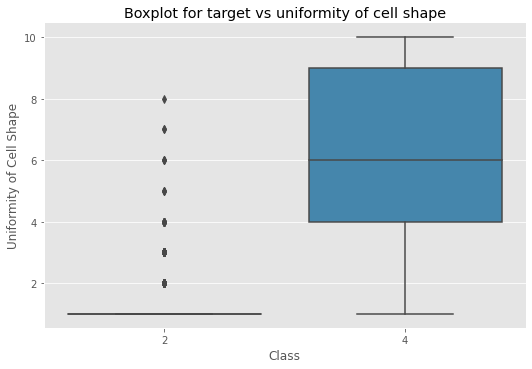

In [252]:
sns.catplot(x="Class", y="Uniformity of Cell Size",
            data=dataset, kind="box", aspect=1.5)
plt.title("Boxplot for target vs Bland Chromatin")
plt.show()

sns.catplot(x="Class", y="Uniformity of Cell Shape",
            data=dataset, kind="box", aspect=1.5)
plt.title("Boxplot for target vs uniformity of cell shape")
plt.show()

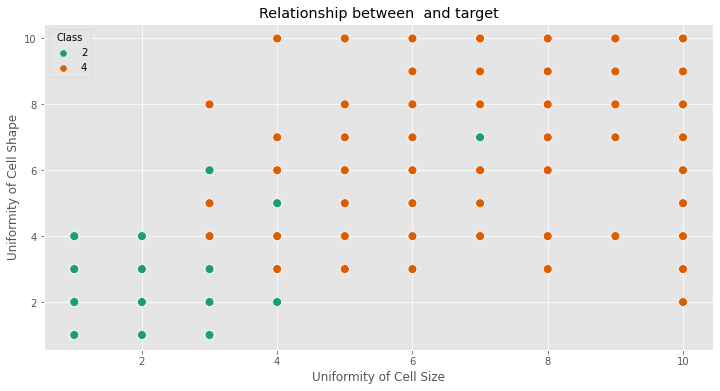

In [253]:

## doesn't really show anything but can have a play around with it
# kind of worth checking the data analyst document


sns.scatterplot(x="Uniformity of Cell Size", y="Uniformity of Cell Shape",
                hue="Class", data=dataset, palette="Dark2", s=80)
plt.title("Relationship between  and target")
plt.show()



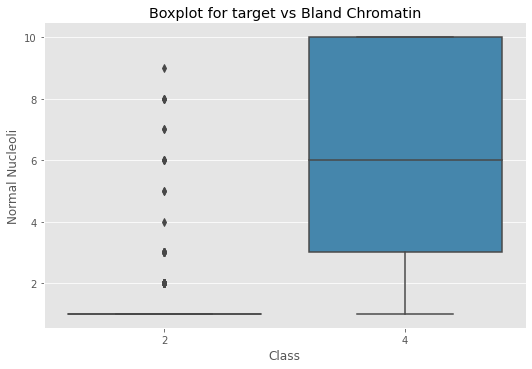

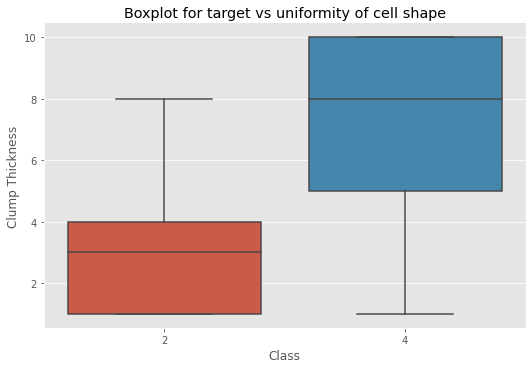

In [254]:
sns.catplot(x="Class", y="Normal Nucleoli",
            data=dataset, kind="box", aspect=1.5)
plt.title("Boxplot for target vs Bland Chromatin")
plt.show()

sns.catplot(x="Class", y="Clump Thickness",
            data=dataset, kind="box", aspect=1.5)
plt.title("Boxplot for target vs uniformity of cell shape")
plt.show()

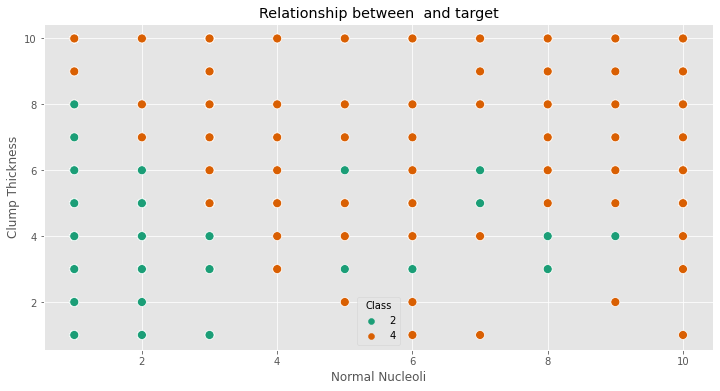

In [255]:

## doesn't really show anything but can have a play around with it
# kind of worth checking the data analyst document


sns.scatterplot(x="Normal Nucleoli", y="Clump Thickness",
                hue="Class", data=dataset, palette="Dark2", s=80)
plt.title("Relationship between  and target")
plt.show()




heatmap to explore relationships

/var/folders/n3/_twj430546db0d30m_f72nrw0000gn/T/ipykernel_35606/2955555514.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = dataset.corr()


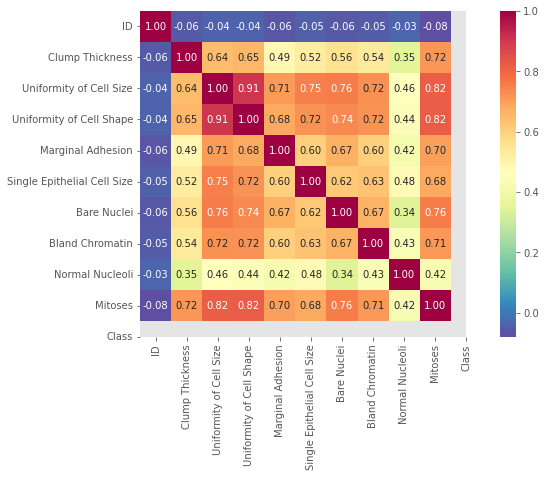

In [256]:
corrmat = dataset.corr()
hm = sns.heatmap(corrmat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=dataset.columns,
                 xticklabels=dataset.columns,
                 cmap="Spectral_r")
plt.show()

Model training and standard model results with arbritary values

In [257]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(max_depth=5, n_estimators=40)

scoring = ['accuracy', 'precision', 'recall', 'f1']

results = model_selection.cross_validate(
        estimator=random_forest_model, X=X, y=y, cv=5, scoring=scoring, return_train_score=True)
print("Mean Training Accuracy: ", results['train_accuracy'].mean()*100,
          "\nMean Training Precision: ", results['train_precision'].mean(),
          "\nMean Training Recall: ", results['train_recall'].mean(),
          "\nMean Training F1 Score: ", results['train_f1'].mean(),
          "\nMean Validation Accuracy: ", results['test_accuracy'].mean()*100,
          "\nMean Validation Precision: ", results['test_precision'].mean(),
          "\nMean Validation Recall: ", results['test_recall'].mean(),
          "\nMean Validation F1 Score: ", results['test_f1'].mean()
          )



Mean Training Accuracy:  98.3549067211858 
Mean Training Precision:  0.9591546464291099 
Mean Training Recall:  0.994813255613126 
Mean Training F1 Score:  0.9766155427814491 
Mean Validation Accuracy:  96.42651593011304 
Mean Validation Precision:  0.9411776546367339 
Mean Validation Recall:  0.9585034013605442 
Mean Validation F1 Score:  0.948858105460108


testing singular parameters 

In [258]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param
    
    # Extract information from the cross validation model
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    

    plt.plot(param_values, test_scores, '-', label = 'test')
    plt.ylim(ymin = -0.5, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, '-')
    plt.ylim(ymin = 0.0, ymax = 1.25)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

In [259]:
# Grid with only the number of trees changed


def parameter_test(model, param_grid, Name):
    
    
    for key in param_grid.keys(): param = key
    # Create the grid search model and fit to the training data
    tree_grid_search = model_selection.GridSearchCV(model, param_grid=param_grid, verbose = 0, n_jobs=-1, cv = 10,
                                    scoring = 'neg_mean_absolute_error')
    tree_grid_search.fit(x_train,y_train)

    return plot_results(tree_grid_search, param, Name)



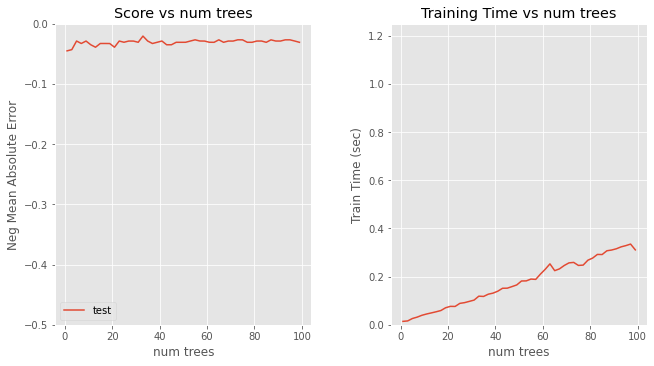

In [260]:
parameter_test(random_forest_model, {'n_estimators': np.arange(1,100,2)}, 'num trees');

as we can see past 50 the absolute error is reduced significantly but affter 50 it plateues and so we should test our models around this value to reduce training time of our grid search

we will now try the max tree depth and see if there is a plateu 

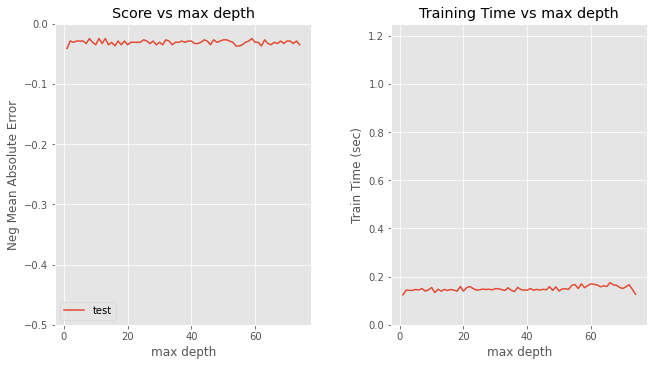

In [261]:
parameter_test(random_forest_model, {'max_depth':np.arange(1,75,1)},'max depth')

max depth is linear so will have very little change however at the start there is a definite increase

now testing the minimum sample split

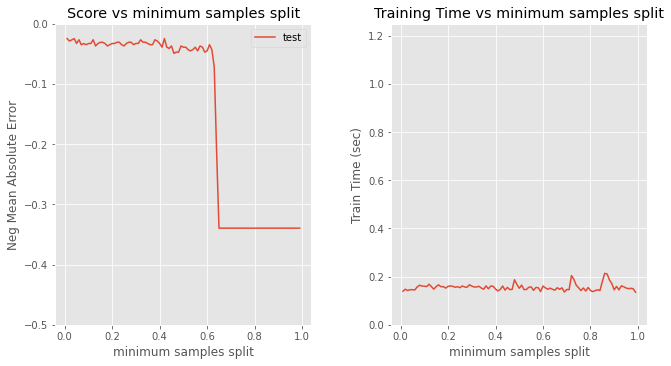

In [262]:
parameter_test(random_forest_model, {'min_samples_split':np.arange(0.01,1,0.01)}, 'minimum samples split')

this decreases as the split increases with a massive drop off at around 0.6 so we should aim to keep this value small

now testing mininmum samples leaf

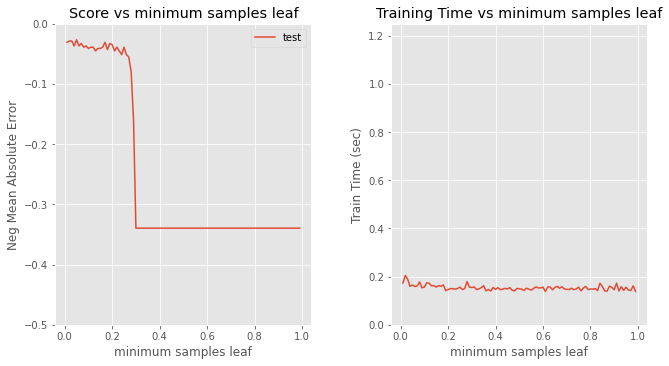

In [263]:
parameter_test(random_forest_model,{'min_samples_leaf': np.arange(0.01, 1,0.01)}, 'minimum samples leaf')



now testing max features

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past beha

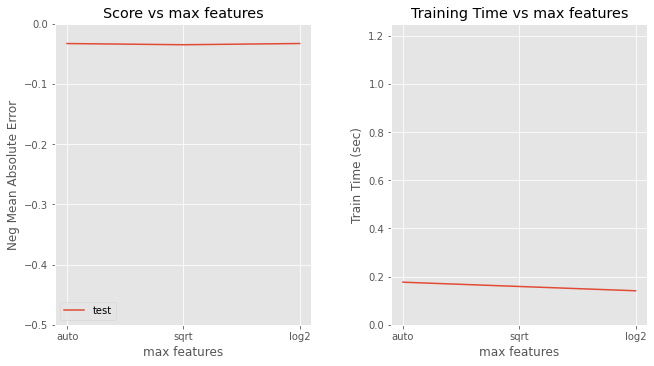

In [264]:
parameter_test(random_forest_model, {'max_features': ['auto','sqrt','log2']},'max features')

as we can see with the current parameters there is not much of a change in score however time is reduced with sqrt and log2

now testing bootstrap

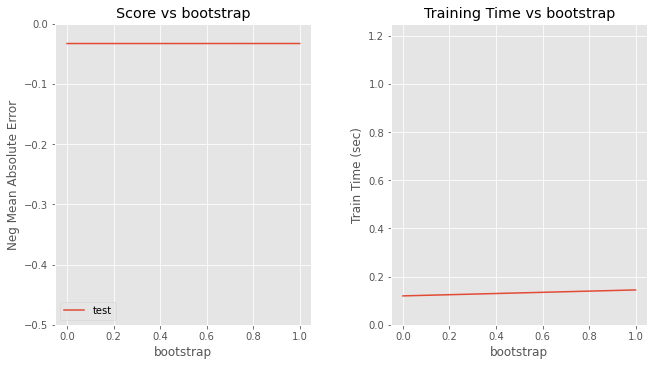

In [265]:
parameter_test(random_forest_model, {'bootstrap': [True, False]}, 'bootstrap')

there isn't much of a change between true and false so I will not include these in the final grid search.

we will use max features as sqrt to save time. minimum sample leaf will be searching at lwoer values and number of smaples will be searching in between 0-50 as there is only a time increase after 50

In [266]:
param_grid = {
    'n_estimators': np.arange(5,50, 10),
    'min_samples_split': np.arange(0.001, 0.6, 0.1),
    'min_samples_leaf': [0.05,0.1,0.15,0.2,0.25,0.3],
    'max_features': ['sqrt'],
}

RFgrid_model = model_selection.GridSearchCV(estimator = random_forest_model, param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, verbose = 1, return_train_score=True)

RFgrid_model.fit(x_train,y_train)

print(RFgrid_model.best_params_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
{'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 0.101, 'n_estimators': 15}


using the best parameters from the returned model here we will do another grid search to refine the parameters even further

In [267]:
param_grid = {
    'n_estimators': np.arange(30,50, 3),
    'min_samples_split': np.arange(0.0001, 0.001, 0.0003),
    'min_samples_leaf': [0.001,0.001,0.002,0.003,0.004,0.005,0.006,0.007],
    'max_features': ['sqrt'],
}

RFgrid2_model = model_selection.GridSearchCV(estimator = random_forest_model, param_grid = param_grid, 
                                 cv = 5, n_jobs = -1, verbose = 1, return_train_score=True)

RFgrid2_model.fit(x_train,y_train)

print(RFgrid2_model.best_params_)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
{'max_features': 'sqrt', 'min_samples_leaf': 0.001, 'min_samples_split': 0.0007, 'n_estimators': 30}


now we will evaluate the increase in accuracy of these models. 

In [300]:
from sklearn import metrics
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels,predictions)
    precision = metrics.precision_score(test_labels, predictions)

    return accuracy;

In [301]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_test, y_test)

now for the first grid search

In [289]:
grid_search = RFgrid_model.best_estimator_

grid_search.fit(x_train,y_train)
first_grid_search_accuracy = evaluate(grid_search, x_test,y_test)

Model Performance
Accuracy = 0.9524%.
precision = 0.9114%.


now the best grid search


In [280]:
best_grid_search = RFgrid2_model.best_estimator_

best_grid_search.fit(x_train,y_train)
grid_final_accuracy = evaluate(best_grid_search, x_test,y_test)

Model Performance
Accuracy = 0.9571%.
precision = 0.9125%.


In [282]:
print('Improvement of {:0.2f}% for the first grid search'.format( 100 * (first_grid_search_accuracy - base_accuracy) / base_accuracy))

print('Improvement of {:0.2f}% for the second grid search'.format( 100 * (grid_final_accuracy - base_accuracy) / base_accuracy))


Improvement of 0.00% for the first grid search
Improvement of 0.50% for the second grid search


as we can see there is minimal improvement after the 2 grid searches so we will stop there and make this our final model

In [291]:
final_model = best_grid_search
print('final model parameters:\n')
print(final_model.get_params(),'\n')
print(evaluate(best_grid_search, x_test,y_test))

final model parameters:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.0007, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 

Model Performance
Accuracy = 0.9571%.
precision = 0.9125%.
0.9571428571428572


comparisons of the models and a barchart visualisation 